In [4]:
"""This file contains code for use with "Think Stats",
by Allen B. Downey, available from greenteapress.com

Copyright 2010 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

import sys
import numpy as np
import thinkstats2
import math
import thinkplot
import random

from collections import defaultdict


def ReadFemResp(dct_file='2002FemResp.dct',
                dat_file='2002FemResp.dat.gz',
                nrows=None):
    """Reads the NSFG respondent data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=nrows)
    CleanFemResp(df)
    return df


def CleanFemResp(df):
    """Recodes variables from the respondent frame.

    df: DataFrame
    """
    pass


def ReadFemPreg(dct_file='2002FemPreg.dct',
                dat_file='2002FemPreg.dat.gz'):
    """Reads the NSFG pregnancy data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df


def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan


def ValidatePregnum(resp, preg):
    """Validate pregnum in the respondent file.

    resp: respondent DataFrame
    preg: pregnancy DataFrame
    """
    # make the map from caseid to list of pregnancy indices
    preg_map = MakePregMap(preg)
    
    # iterate through the respondent pregnum series
    for index, pregnum in resp.pregnum.iteritems():
        caseid = resp.caseid[index]
        indices = preg_map[caseid]

        # check that pregnum from the respondent file equals
        # the number of records in the pregnancy file
        if len(indices) != pregnum:
            print(caseid, len(indices), pregnum)
            return False

    return True


def MakePregMap(df):
    """Make a map from caseid to list of preg indices.

    df: DataFrame

    returns: dict that maps from caseid to list of indices into `preg`
    """
    d = defaultdict(list)
    for index, caseid in df.caseid.iteritems():
        d[caseid].append(index)
    return d


def main():
    """Tests the functions in this module.

    script: string script name
    """
    # read and validate the respondent file
    resp = ReadFemResp()

    assert(len(resp) == 7643)
    assert(resp.pregnum.value_counts()[1] == 1267)

    # read and validate the pregnancy file
    preg = ReadFemPreg()
    print(preg.shape)

    assert len(preg) == 13593
    assert preg.caseid[13592] == 12571
    assert preg.pregordr.value_counts()[1] == 5033
    assert preg.nbrnaliv.value_counts()[1] == 8981
    assert preg.babysex.value_counts()[1] == 4641
    assert preg.birthwgt_lb.value_counts()[7] == 3049
    assert preg.birthwgt_oz.value_counts()[0] == 1037
    assert preg.prglngth.value_counts()[39] == 4744
    assert preg.outcome.value_counts()[1] == 9148
    assert preg.birthord.value_counts()[1] == 4413
    assert preg.agepreg.value_counts()[22.75] == 100
    assert preg.totalwgt_lb.value_counts()[7.5] == 302

    weights = preg.finalwgt.value_counts()
    key = max(weights.keys())
    assert preg.finalwgt.value_counts()[key] == 6

    # validate that the pregnum column in `resp` matches the number
    # of entries in `preg`
    assert(ValidatePregnum(resp, preg))

    
    print('All tests passed.')


if __name__ == '__main__':
    main()

(13593, 244)
All tests passed.


C:\Users\brean\AppData\Local\Temp\ipykernel_15368\3399610791.py:120: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, caseid in df.caseid.iteritems():
C:\Users\brean\AppData\Local\Temp\ipykernel_15368\3399610791.py:99: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, pregnum in resp.pregnum.iteritems():


Page 35-36: 3-1 something like the class size paradox appears if you survey children adn ask how many children are in their fmaily. families with many children are more likely to appear in your sample and families with no children have no chance to be in the sample. use the NSFG respondant variable NUMKDHH to construct the actual distribution for the number of children under 18 in the household. Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18(including themselves) are in their household. Plot the actual adn biased distributions, and compute their means. 

C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())


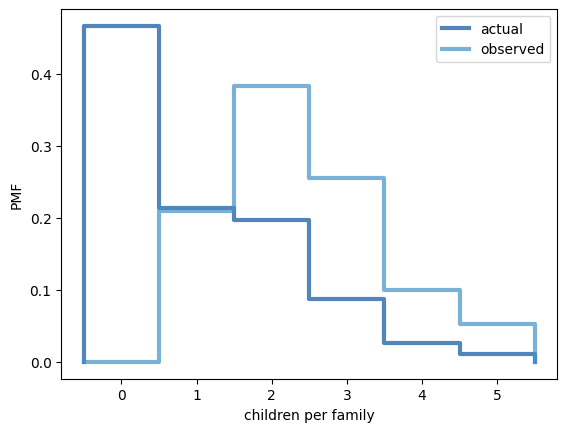

mean of actual 1.024205155043831
mean of biased 2.403679100664282


<Figure size 800x600 with 0 Axes>

In [5]:
resp = ReadFemResp()
pmf_resp = thinkstats2.Pmf(resp.numkdhh, label='actual')


def BiasPmf(pmf_resp,label):
    new_pmf = pmf_resp.Copy(label = label)
    for x, p in pmf_resp.Items():
        new_pmf.Mult(x,x)
    new_pmf.Normalize()
    return new_pmf

bias_pmf = BiasPmf(pmf_resp, label = 'observed')
thinkplot.PrePlot(2)
thinkplot.pmfs([pmf_resp, bias_pmf])
thinkplot.Show(xlabel='children per family', ylabel = "PMF")

print("mean of actual", pmf_resp.Mean())
print("mean of biased", bias_pmf.Mean())



Page 36: 3-2 (In “Summarizing Distributions” on page 22 we computed the mean of a sample by adding up the elements and dividing by n). if you are given a PMF, you can still compute the mean but the process is slight different. Write functions called PmfMean and PmfVar that take a Pmf object and compute the mean and variance. To test these methods, check that they are consistent with the methods Mean adn Var provided by Pmf


In [6]:
def PmfMean(pmf):
    mean = 0
    for x in pmf.Values():
        p = pmf.Prob(x)
        mean += p * x
    return mean

def PmfVar(pmf):
    mean = PmfMean(pmf)
    var = 0
    for x in pmf.Values():
        p = pmf.Prob(x)
        var += p *(x - mean)**2
    return var

print(PmfMean(pmf_resp) == pmf_resp.Mean())
print(PmfVar(pmf_resp) == pmf_resp.Var())

True
True


Page 47: 4-1 How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution forothers. I weighed 7.95 lbs at birth. Please use python to code this and please post the results of the code! Thank you!

In [7]:
#7lb 1oz

preg = ReadFemPreg()
live = preg[preg.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

mine = 7.0625
other = others.totalwgt_lb

def PercentileRank(other, mine):
    count = 0
    for weight in other:
        if weight <= mine:
            count += 1
    rank = 100 * count / len(other)
    return rank
print(PercentileRank(other, mine))

39.66209081309398


Page 48: 4-2 The numbers generated by random.random are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability. Generate 1000 numbers from random.random and plot their PMF and CDF. is the distribution uniform? 

{'xscale': 'linear', 'yscale': 'linear'}

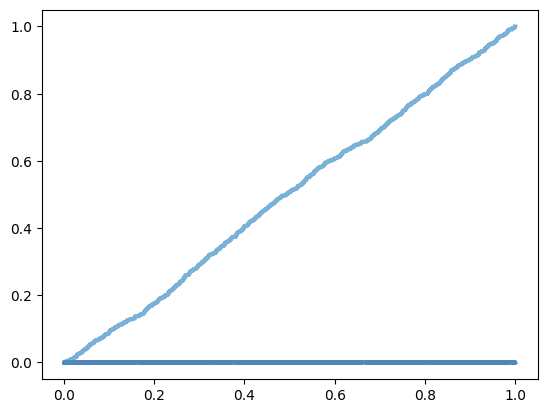

In [22]:
generated = np.random.random(size=1000)

random_pmf = thinkstats2.Pmf(generated, label = 'pmf')
random_cdf = thinkstats2.Cdf(generated, label = 'cdf')
thinkplot.PrePlot(2)
thinkplot.pmf(random_pmf)
thinkplot.cdf(random_cdf)

#yes, this is a uniform distribution